<h3>  &nbsp;&nbsp;Train on GPU&nbsp;&nbsp; <a href="https://cloud.google.com/tpu/"><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/tpu-hexagon.png" width="50"></a></h3>

1. On the main menu, click Runtime and select **Change runtime type**. Set "GPU" as the hardware accelerator.
1. Click Runtime again and select **Runtime > Run All**. You can also run the cells manually with Shift-ENTER. 

In [1]:
import tensorflow.keras as keras
keras.__version__

'2.4.0'

In [2]:
import numpy as np
import tensorflow
import re
import sklearn.model_selection as sk

In [3]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

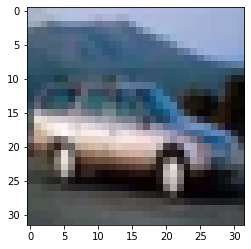

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

train_images

digit = train_images[4]
plt.imshow(digit, cmap=plt.cm.binary)

plt.show()

In [5]:
# MODIFY THE CODE TO ADD A VALIDATION SET

train_images = train_images.reshape((50000, 32, 32, 3))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 32, 32, 3))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

test_images, validation_images,  test_labels, validation_labels = sk.train_test_split(test_images, test_labels, test_size=0.5)

In [6]:
#VGG gives very poor results, probably due to too many parameters
#Xception goes around 0.7 acc when used with images of (72,72); 0.

In [7]:
from tensorflow.keras.applications import DenseNet121

input_tensor = keras.Input(shape=(32, 32, 3))
resized_images = keras.layers.Lambda(lambda image: tensorflow.image.resize(image, (200, 200)))(input_tensor)


conv_base = DenseNet121(weights='imagenet',
                  include_top=False,
                  input_tensor=resized_images,
                  pooling='avg',
                  input_shape=(200, 200, 3))

In [8]:
#conv_base.summary()

In [9]:
conv_base.trainable = False

In [10]:
initializer = keras.initializers.he_normal()

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, 
                       kernel_initializer=initializer,
                       activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10,
                       kernel_initializer=initializer,
                       activation='sigmoid'))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 1024)              7037504   
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               262400    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 7,302,474
Trainable params: 264,970
Non-trainable params: 7,037,504
_________________________________________________________________


In [12]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

lr_reduce = tensorflow.keras.callbacks.ReduceLROnPlateau(monitor='val_acc',
                                          factor=0.2,
                                          patience=2,
                                          verbose=1,
                                          mode='max',
                                          min_lr=1e-7)

In [13]:
  # MAKE WHATEVER CHANGES ARE NECESSARY
  # TO GET 0.7 ACCURACY ON THE TEST SET

model_hist = model.fit(train_images, train_labels,
          epochs=20, batch_size=128, callbacks=[lr_reduce], validation_data=(validation_images, validation_labels))
          # ADD VALIDATION HERE)

Epoch 1/20
391/391 [==============================] - 70s 179ms/step - loss: 1.5612 - acc: 0.4551 - val_loss: 0.9036 - val_acc: 0.7238
Epoch 2/20
391/391 [==============================] - 67s 172ms/step - loss: 0.9952 - acc: 0.6686 - val_loss: 0.7226 - val_acc: 0.7676
Epoch 3/20
391/391 [==============================] - 68s 174ms/step - loss: 0.8358 - acc: 0.7208 - val_loss: 0.6473 - val_acc: 0.7814
Epoch 4/20
391/391 [==============================] - 67s 172ms/step - loss: 0.7536 - acc: 0.7459 - val_loss: 0.6045 - val_acc: 0.7980
Epoch 5/20
391/391 [==============================] - 67s 172ms/step - loss: 0.6999 - acc: 0.7646 - val_loss: 0.5807 - val_acc: 0.8042
Epoch 6/20
391/391 [==============================] - 67s 171ms/step - loss: 0.6621 - acc: 0.7755 - val_loss: 0.5609 - val_acc: 0.8118
Epoch 7/20
391/391 [==============================] - 65s 166ms/step - loss: 0.6338 - acc: 0.7850 - val_loss: 0.5442 - val_acc: 0.8170
Epoch 8/20
391/391 [==============================] - 6

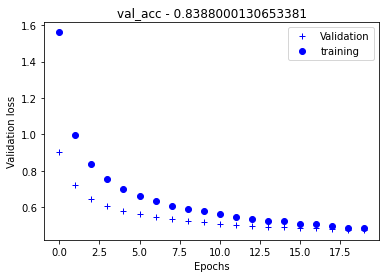

In [14]:
import matplotlib.pyplot as plt

epochs = range(0, 20)
train_loss = model_hist.history['loss']
val_loss= model_hist.history['val_loss']
val_acc = model_hist.history['val_acc'][-1]

plt.plot(epochs, val_loss, 'b+', label='Validation')
plt.plot(epochs, train_loss, 'bo', label='training')
plt.title('val_acc - {}'.format(val_acc))
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()
plt.savefig('DenseNet121.png')
plt.show()


In [15]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('test_acc:', test_acc)
test_loss

157/157 [==============================] - 6s 39ms/step - loss: 0.4804 - acc: 0.8410
test_acc: 0.8410000205039978


0.48039764165878296

In [16]:
model.save_weights('./cifar10.h5', overwrite=True)